# Bayesian Linear Regression Tutorial

## Import code

In [1]:
from LR import *

from scipy.stats import linregress
import matplotlib.pyplot as plt 

# update plot parameters
params = {'legend.fontsize': 12,
          'figure.figsize': (12, 9),
          'lines.linewidth':4,
         'axes.labelsize': 20,
         'axes.titlesize':24,
          'axes.linewidth':4,
         'xtick.labelsize':22,
         'ytick.labelsize':22}
plt.rcParams.update(params)
plt.rcParams['pdf.fonttype'] = 42

## Model definition

Want to predict a single output $y \in \mathbb{R}$ given a vector of features $\mathbf{x} \in \mathbb{R}^d$ 

By defining a basis function $\phi: \mathbb{R}^d \rightarrow \mathbb{R}^m$, the model predicts $y$ as a linear combination of potentially non-linear functions of $\mathbf{x}$, weighted by regression coefficients $\mathbf{w} \in \mathbb{R}^m$.  

$$
y = \mathbf{w}^T \phi (\mathbf{x}) + \varepsilon
$$

The model assumes that measurements are corrupted by zero-mean Gaussian noise with precision $\beta$, 


$$
\varepsilon \sim \mathcal{N}(\varepsilon | 0, \beta^{-1})
$$

## Example with $\phi_i(\mathbf{x}) = x_i$

In this example, Scikit-learn's make_regression() is used to generate synthetic data with 100 features, 1 target variable, and 150 samples. Gaussian noise is added to the output variable with a standard deviation of 10, which corresponds to a precision of $\frac{1}{10^{2}}$ = .01.  

In [2]:
import sklearn.datasets
import numpy as np

# number of samples
NS = 150
# number of features
NF = 100 
# define precision as beta
noise = 10        # std deviation 
beta = 1/noise**2 # inverse variance 

X, y = sklearn.datasets.make_regression(n_samples=NS, n_features=NF, n_targets=1, noise=noise)

Decompose data set into training and testing data, setting aside 1/5 of the data for testing. 

In [3]:
N_train = int(.8*NS)

X_train = X[:N_train, :] 
X_test = X[N_train:, :]
Y_train = y[:N_train]
Y_test = y[N_train:]

Fit a Bayesian linear regression model and maximize evidence function

In [4]:
blr = BLR(X_train, Y_train)
blr.fit()

Evidence: -923.403
Evidence: -799.826
Evidence: -781.380
Evidence: -773.770
Evidence: -769.776
Evidence: -767.401
Evidence: -765.872
Evidence: -764.833
Evidence: -764.098


Make Predictions on test data 

In [5]:
Y, Y_stdv = blr.predict(X_test)

Plot results

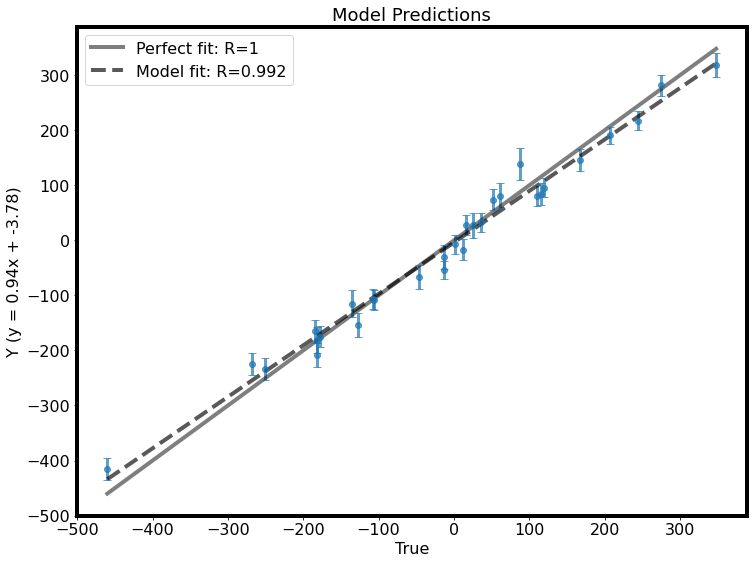

In [6]:
OneToOne = np.linspace(np.min(Y_test), np.max(Y_test), 100)
plt.plot(OneToOne, OneToOne, 'k', alpha=.5, label="Perfect fit: R=1")

lr_stats = linregress(Y_test, Y)
y_fit = OneToOne*lr_stats.slope + lr_stats.intercept

plt.plot(OneToOne, y_fit, 'k--', alpha=.65, label=r"Model fit: R={:.3f}".format(lr_stats.rvalue))
plt.errorbar(Y_test, Y, linewidth=3, capsize=4, linestyle='none', marker='o', alpha=.7, yerr = Y_stdv)

plt.legend(fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("True", fontsize=16)
plt.ylabel("Y (y = {:.2f}x + {:.2f})".format(lr_stats.slope, lr_stats.intercept), fontsize=16)
plt.title(r"Model Predictions", fontsize=18)
plt.savefig("Figures/example_1.png", dpi=100)
plt.show()

## Example with $\phi_i(\mathbf{x}) = [1, x_i, x_i^2, ..., x_i^5]^T$

Generate data with response that is non-linear in x

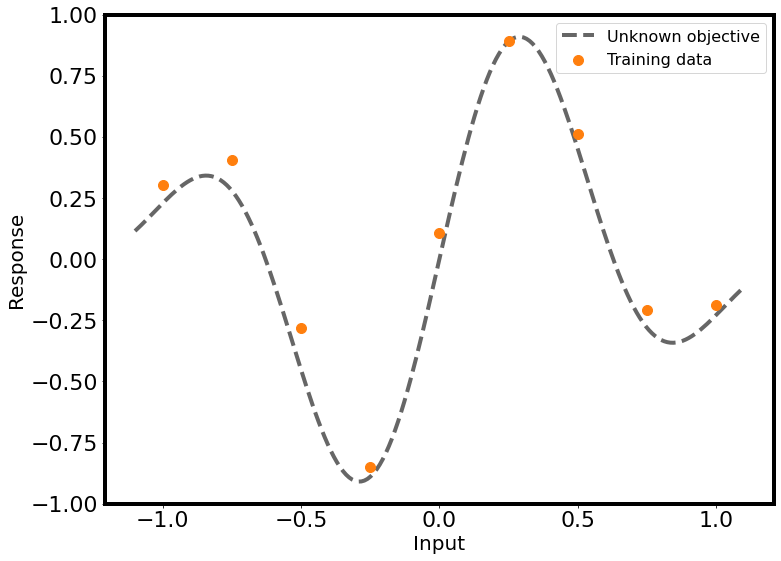

In [7]:
def f(x, noise):
    return np.sin(5 * x) * (1 - np.tanh(x ** 2)) + np.random.randn() * noise/100

def generate_data(Xlist, noise=0.):
    Nsamples = len(Xlist)
    X = np.zeros([Nsamples, 1])
    Y = np.zeros(Nsamples)
    
    for i in range(Nsamples):
        X[i, :] = Xlist[i]
        # add some standard Gaussian noise to Y
        Y[i] = f(Xlist[i], noise)

    return np.vstack(X), np.vstack(Y)

# train data points
Xlist = [-1, -.75, -.5, -.25, 0, .25, .5, .75, 1]
X_train, Y_train = generate_data(Xlist, noise=10.0)
X_test, Y_test = generate_data(list(np.linspace(-1.1, 1.1, 200)))

inds = np.argsort(np.ravel(X_train))

plt.plot(X_test.ravel(), Y_test.ravel(), 'k--', alpha=.6, label='Unknown objective', zorder=2)
plt.scatter(X_train[inds].ravel(), Y_train[inds].ravel(), c='C1', s=100, label='Training data', zorder=4)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(fontsize=16)
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()

Define basis function

In [8]:
def x_basis(X):
    b = np.vstack(np.ones(X.shape[0]))
    return np.concatenate((b, X, X**2, X**3, X**4, X**5), -1)

Fit a Bayesian linear regression model and maximize evidence function

In [9]:
blr = BLR(x_basis(X_train), Y_train)
blr.fit()

Evidence: -13.962
Evidence: -12.454
Evidence: -11.678
Evidence: -11.264
Evidence: -11.037
Evidence: -10.912
Evidence: -10.861
Evidence: -10.868


Make predictions on test data

In [10]:
Y, Y_stdv = blr.predict(x_basis(X_test))

Plot results

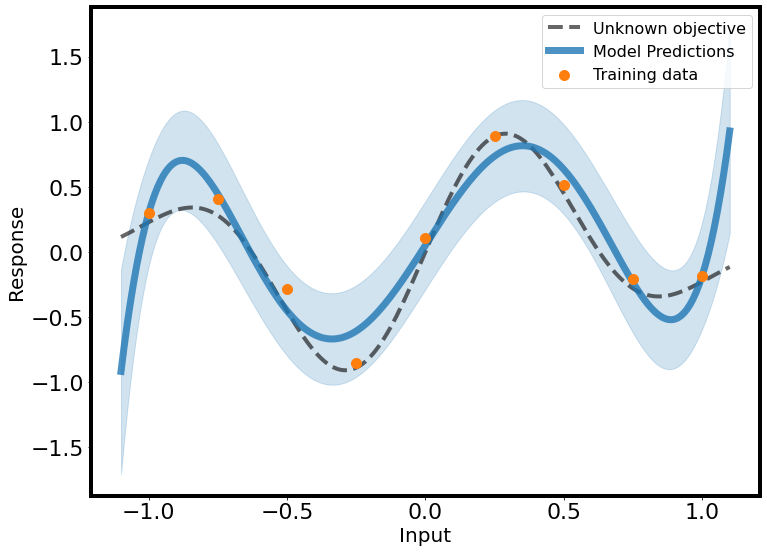

In [11]:
inds = np.argsort(np.ravel(X_train))

plt.plot(X_test.ravel(), Y_test.ravel(), 'k--', alpha=.6, label='Unknown objective', zorder=2)
plt.scatter(X_train[inds].ravel(), Y_train[inds].ravel(), c='C1', s=100, label='Training data', zorder=4)

plt.plot(X_test.ravel(), Y.ravel(), c='C0', alpha=.8, label='Model Predictions', zorder=3, linewidth=7)
unc_factor = 1. 
plt.fill_between(X_test.ravel(), Y - unc_factor*Y_stdv, Y + unc_factor*Y_stdv, 
                 color='C0', alpha=0.2, zorder=1)
#plt.title("Maximum A Posteriori")
handles, labels = plt.gca().get_legend_handles_labels()
#plt.ylim([-1.9, 1.5])
plt.legend(fontsize=16)
plt.xlabel("Input")
plt.ylabel("Response")
plt.savefig("Figures/example_2.png", dpi=100)
plt.show()